In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/respiratory-sound-database/demographic_info.txt
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/filename_format.txt
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/filename_differences.txt
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/168_1b1_Al_sc_Meditron.txt
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/172_1b4_Ar_mc_AKGC417L.txt
/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Pl_mc_AKGC417L.wav
/kaggle/input/resp

In [2]:
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from scipy.io import wavfile
from tqdm import tqdm

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.utils import to_categorical, normalize
from keras.layers import Conv1D, Dense, LSTM, Flatten, Dropout, MaxPooling1D

In [3]:
diagnosis_df = pd.read_csv('/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', 
                           names=['Patient number', 'Diagnosis'])

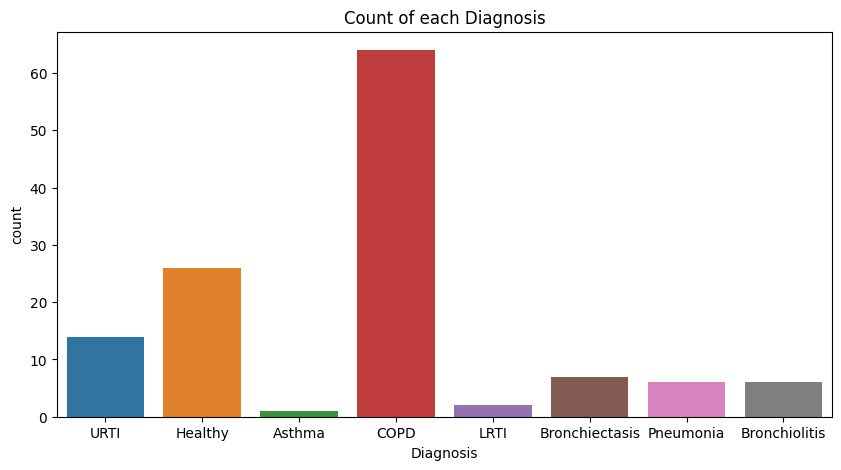

In [4]:

plt.figure(figsize=(10,5))
sns.countplot(diagnosis_df, x='Diagnosis')
plt.title('Count of each Diagnosis')
plt.show()

In [5]:
patient_df = pd.read_csv('/kaggle/input/respiratory-sound-database/demographic_info.txt', 
                         names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                         delimiter = ' ')

In [6]:
patient_df.head()

Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F                NaN               19.0   
1             102   0.75   F                NaN                9.8   
2             103  70.00   F              33.00                NaN   
3             104  70.00   F              28.47                NaN   
4             105   7.00   F                NaN               32.0   

   Child Height (cm)  
0               99.0  
1               73.0  
2                NaN  
3                NaN  
4              135.0

In [7]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

51

In [8]:
for i in range(len(patient_df)):
    if (pd.isna(patient_df['Adult BMI (kg/m2)'][i])) and (not pd.isna(patient_df['Child Weight (kg)'][i])) and (not pd.isna(patient_df['Child Height (cm)'][i])):
        patient_df['Adult BMI (kg/m2)'][i] = round(patient_df['Child Weight (kg)'][i]/np.square(0.01*patient_df['Child Height (cm)'][i]),2)

In [9]:
patient_df['Adult BMI (kg/m2)'].isna().sum()

9

In [10]:
df = pd.merge(left=patient_df, right=diagnosis_df, how='left')
df.head()

Patient number    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0             101   3.00   F              19.39               19.0   
1             102   0.75   F              18.39                9.8   
2             103  70.00   F              33.00                NaN   
3             104  70.00   F              28.47                NaN   
4             105   7.00   F              17.56               32.0   

   Child Height (cm) Diagnosis  
0               99.0      URTI  
1               73.0   Healthy  
2                NaN    Asthma  
3                NaN      COPD  
4              135.0      URTI

In [11]:
Patient_numbers, Recording_indices, Chest_locations, Acquisition_modes, Recording_equipments = [], [], [], [], []
folder_path = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        parts = filename.split('_')
        Patient_number = parts[0]
        Recording_index = parts[1]
        Chest_location = parts[2]
        Acquisition_mode = parts[3]
        Recording_equipment = parts[4].split('.')[0]
        
        Patient_numbers.append(int(Patient_number))
        Recording_indices.append(Recording_index)
        Chest_locations.append(Chest_location)
        Acquisition_modes.append(Acquisition_mode)
        Recording_equipments.append(Recording_equipment)

df1 = pd.DataFrame({'Patient number': Patient_numbers, 'Recording index': Recording_indices, 'Chest location': Chest_locations,
                    'Acquisition mode': Acquisition_modes, 'Recording equipment': Recording_equipments})

In [12]:
df1.tail()

Patient number Recording index Chest location Acquisition mode  \
915             200             2p4             Pr               mc   
916             156             8b3             Ll               mc   
917             162             2b3             Ar               mc   
918             162             2b4             Pr               mc   
919             200             2p3             Ar               mc   

    Recording equipment  
915            AKGC417L  
916            AKGC417L  
917            AKGC417L  
918            AKGC417L  
919            AKGC417L

In [13]:
df_all = pd.merge(left=df1, right=df, how='left').sort_values('Patient number').reset_index(drop=True)
df_all.head()

Patient number Recording index Chest location Acquisition mode  \
0             101             1b1             Al               sc   
1             101             1b1             Pr               sc   
2             102             1b1             Ar               sc   
3             103             2b2             Ar               mc   
4             104             1b1             Al               sc   

  Recording equipment    Age Sex  Adult BMI (kg/m2)  Child Weight (kg)  \
0            Meditron   3.00   F              19.39               19.0   
1            Meditron   3.00   F              19.39               19.0   
2            Meditron   0.75   F              18.39                9.8   
3            LittC2SE  70.00   F              33.00                NaN   
4            Litt3200  70.00   F              28.47                NaN   

   Child Height (cm) Diagnosis  
0               99.0      URTI  
1               99.0      URTI  
2               73.0   Healthy  
3                NaN    Asthma  
4                NaN      COPD

In [14]:
df_all['audio_file_name'] = df_all.apply(lambda row: str(row['Patient number']) +'_'+ str(row['Recording index']) +'_'+ str(row['Chest location']) 
                             +'_'+ str(row['Acquisition mode']) +'_'+ str(row['Recording equipment']) + '.wav', axis=1)

In [15]:
df_main = df_all[['Patient number','audio_file_name', 'Diagnosis']]
df_main.head(20)

Patient number             audio_file_name Diagnosis
0              101  101_1b1_Al_sc_Meditron.wav      URTI
1              101  101_1b1_Pr_sc_Meditron.wav      URTI
2              102  102_1b1_Ar_sc_Meditron.wav   Healthy
3              103  103_2b2_Ar_mc_LittC2SE.wav    Asthma
4              104  104_1b1_Al_sc_Litt3200.wav      COPD
5              104  104_1b1_Ll_sc_Litt3200.wav      COPD
6              104  104_1b1_Ar_sc_Litt3200.wav      COPD
7              104  104_1b1_Lr_sc_Litt3200.wav      COPD
8              104  104_1b1_Pl_sc_Litt3200.wav      COPD
9              104  104_1b1_Pr_sc_Litt3200.wav      COPD
10             105  105_1b1_Tc_sc_Meditron.wav      URTI
11             106  106_2b1_Pl_mc_LittC2SE.wav      COPD
12             106  106_2b1_Pr_mc_LittC2SE.wav      COPD
13             107  107_2b3_Pl_mc_AKGC417L.wav      COPD
14             107  107_2b3_Al_mc_AKGC417L.wav      COPD
15             107  107_2b4_Ar_mc_AKGC417L.wav      COPD
16             107  107_2b3_Ar_mc_AKGC417L.wav      COPD
17             107  107_2b3_Lr_mc_AKGC417L.wav      COPD
18             107  107_2b4_Ll_mc_AKGC417L.wav      COPD
19             107  107_2b5_Pl_mc_AKGC417L.wav      COPD

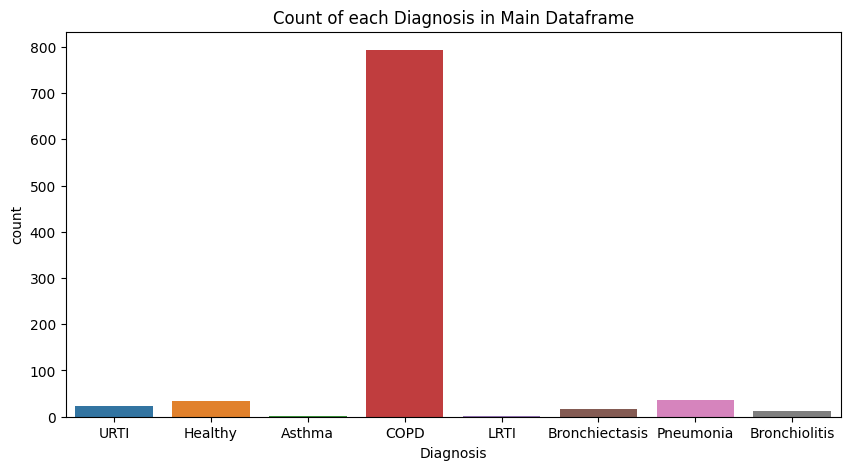

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(df_main, x='Diagnosis')
plt.title('Count of each Diagnosis in Main Dataframe')
plt.show()

In [17]:
df_main = df_main[(df_main['Diagnosis'] != 'Asthma') & (df_main['Diagnosis'] != 'LRTI')]
df_main = df_main.sort_values('Patient number').reset_index(drop=True)

In [18]:
df_main['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

In [19]:
df_main['Diagnosis'].value_counts(normalize=True)*100

Diagnosis
COPD              86.477644
Pneumonia          4.034896
Healthy            3.816794
URTI               2.508179
Bronchiectasis     1.744820
Bronchiolitis      1.417666
Name: proportion, dtype: float64

In [20]:
audio_files_path = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
audio_files = glob(os.path.join(audio_files_path, '**/*.wav'), recursive=True)

In [21]:
# Example Audio File
ipd.Audio(audio_files[0])

In [22]:
y, sr = librosa.load(audio_files[0])
print(len(y))
print(sr)

441000
22050


In [23]:
classes = list(df_main['Diagnosis'].unique())
print(classes)

['URTI', 'Healthy', 'COPD', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']


# Preprocessing

In [24]:
def envelope(y, sr, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_rolling = y.rolling(window=int(sr/10), min_periods=1, center=True).mean()
    for i in y_rolling:
        if i > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [25]:
folder_path = '/kaggle/working/' + 'wavfiles_cleaned'
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

os.makedirs(folder_path, exist_ok=True)

In [26]:
for i in tqdm(df_main['audio_file_name']):
    y, sr = librosa.load(audio_files_path + str(i), sr=22050)
    mask = envelope(y, sr, 0.0005)
    wavfile.write(filename='/kaggle/working/wavfiles_cleaned/' + str(i), rate=sr, data=y[mask])

100%|██████████| 917/917 [02:47<00:00,  5.47it/s]


features: mfccs, chromagrams, mel_specs, spec_contrasts, tonal_centroids

In [27]:
def parser(row):
    audio_file_name = os.path.join('/kaggle/working/wavfiles_cleaned', str(row['audio_file_name']))
    y, sr = librosa.load(audio_file_name, sr=22050)
    
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=24).T, axis=0)
    chromagrams = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=24).T, axis=0)
    mel_specs = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,).T, axis=0)
    spec_contrasts = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6).T, axis=0)
    tonal_centroids = np.mean(librosa.feature.tonnetz(y=y, sr=sr).T, axis=0)
    
    features = np.concatenate([mfccs, chromagrams, mel_specs, spec_contrasts, tonal_centroids], axis=0)
    labels = row['Diagnosis']
    
    return [features, labels]

In [28]:
data = df_main.apply(parser, axis=1).tolist()

In [29]:
data[0]

[array([-5.28425232e+02,  1.04517365e+02,  6.99075851e+01,  4.25721245e+01,
         3.12133808e+01,  2.74905739e+01,  2.22070045e+01,  1.65510998e+01,
         1.52766991e+01,  1.66802998e+01,  1.46422129e+01,  8.42692280e+00,
         3.85719275e+00,  4.90536928e+00,  8.39979267e+00,  9.31068325e+00,
         6.85324955e+00,  3.96354818e+00,  2.85693669e+00,  3.38714695e+00,
         4.46284723e+00,  5.35197639e+00,  5.60875750e+00,  4.76154613e+00,
         7.04114377e-01,  7.25346029e-01,  7.53667116e-01,  7.85776258e-01,
         8.21523905e-01,  8.57331336e-01,  8.85435402e-01,  9.12920773e-01,
         9.36038494e-01,  9.47170556e-01,  9.36003447e-01,  9.06397760e-01,
         8.76736343e-01,  8.52024317e-01,  8.22968423e-01,  7.92576432e-01,
         7.69667625e-01,  7.48739421e-01,  7.18671262e-01,  6.88562870e-01,
         6.66394711e-01,  6.43055558e-01,  6.43532872e-01,  6.76925778e-01,
         4.62663383e+01,  1.86256199e+01,  6.16175699e+00,  2.87840915e+00,
         1.0

In [30]:
X = np.array(list(zip(*data))[0])
y = np.array(list(zip(*data))[1])

In [31]:
df_main['Diagnosis'].value_counts()

Diagnosis
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

# Resampling

In [32]:
# Defining the desired number of samples per minority class (as a dictionary) for over-sampling
sampling_strategy_over = {'Pneumonia': 150, 'Healthy': 150, 'URTI': 100, 'Bronchiectasis': 100, 'Bronchiolitis': 100}

# Creating the SMOTE object for over-sampling minority classes
smote = SMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=5, random_state=42)

# Applying SMOTE to oversample minority classes
X_resampled_over, y_resampled_over = smote.fit_resample(X, y)

# Removing half of the "COPD" samples
copd_indices = np.where(y_resampled_over == 'COPD')[0]
np.random.seed(42)
np.random.shuffle(copd_indices)
remove_indices = copd_indices[:len(copd_indices) // 2]

X_resampled = np.delete(X_resampled_over, remove_indices, axis=0)
y_resampled = np.delete(y_resampled_over, remove_indices)

In [33]:
np.unique(y_resampled, return_counts=True)


(array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
        'URTI'], dtype='<U14'),
 array([100, 100, 397, 150, 150, 100]))

In [34]:
print('Shape of X is',X_resampled.shape)
print('Shape of y is',y_resampled.shape)

Shape of X is (997, 189)
Shape of y is (997,)


In [35]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)
y_resampled = to_categorical(y_encoded)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [37]:
# Reshape training data
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 189, 1))

# Reshape testing data
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 189, 1))

> **model1: simple 1D model**

In [38]:
input_shape = (189, 1)
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))

# Dropout layer
model1.add(Dropout(0.5))

# Flatten layer
model1.add(Flatten())

# Dense layer
model1.add(Dense(6, activation='softmax'))

In [39]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 187, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        71,814 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,070 (281.52 KB)

 Trainable params: 72,070 (281.52 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
model1.fit(X_train_reshaped, y_train, batch_size=32, epochs=125, validation_split=0.25, verbose=0)


In [42]:
model1.save('/kaggle/working/fcn.h5')

In [43]:
model1.evaluate(X_test_reshaped, y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.2930 


[0.27064844965934753, 0.8849999904632568]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


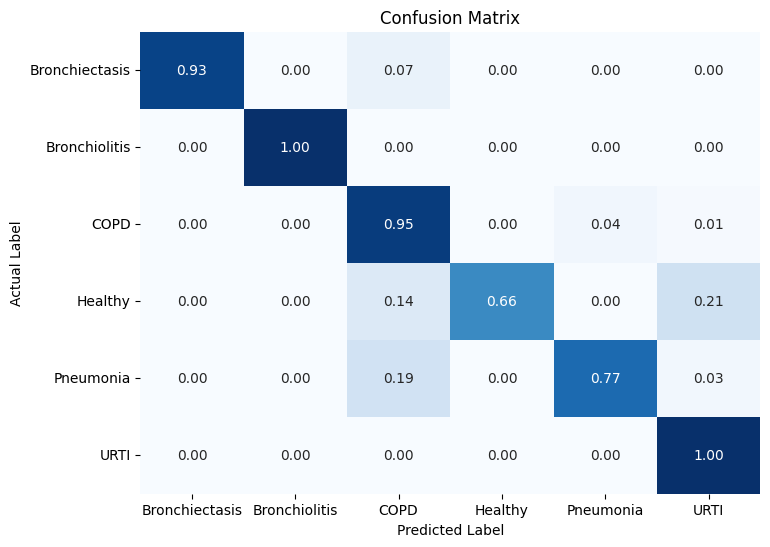

In [44]:
# Confusion Matrix
predictions = model1.predict(X_test_reshaped)

predicted_classes = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       1.00      1.00      1.00        18
           2       0.86      0.95      0.90        79
           3       1.00      0.66      0.79        29
           4       0.89      0.77      0.83        31
           5       0.67      1.00      0.80        16

    accuracy                           0.89       200
   macro avg       0.90      0.88      0.88       200
weighted avg       0.90      0.89      0.88       200



> **model2: pretrained MobileNet**

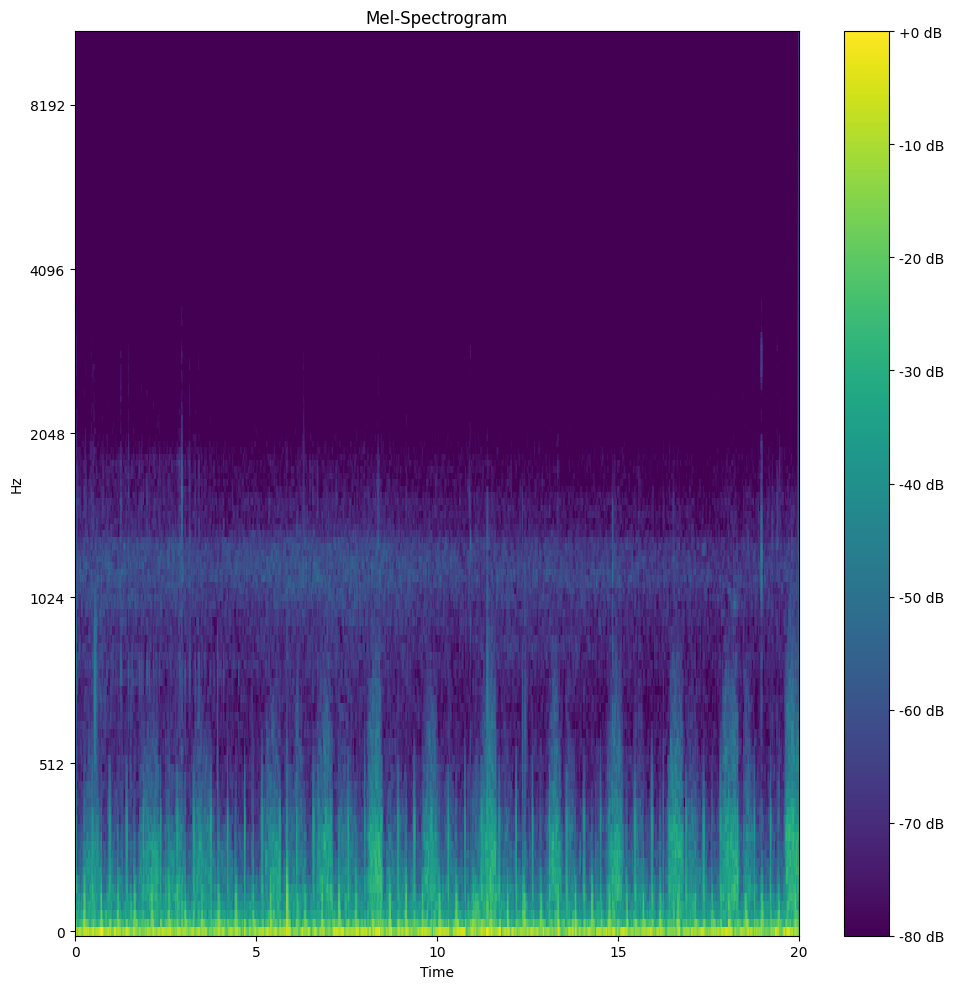

In [46]:
audio_file_path = '/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav'

# Bước 1: Load file âm thanh
y, sr = librosa.load(audio_file_path, sr=22050)

# Bước 2: Tính Mel-Spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Chuyển đổi sang thang dB

# Bước 3: Vẽ Mel-Spectrogram
plt.figure(figsize=(10, 10))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.tight_layout()
plt.savefig('/kaggle/working/mel_spectrogram.png')  # Lưu ảnh
plt.show()